In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib import rcParams, cm
from astropy.visualization import MinMaxInterval, AsinhStretch, ImageNormalize
from matplotlib.lines import Line2D
%matplotlib inline
from ovejero import forward_modeling, model_trainer
import os
import corner

KeyboardInterrupt: 

# Comparing Performance to Forward Modeling

__Author:__ Sebastian Wagner-Carena

__Created:__ 04/01/2020

__Last Run:__ 04/01/2020

__Goals:__ Compare the performance of the BNN model to a forward modeling approach

## Forward Modeling NN1

In [ ]:
root_path = os.getcwd()[:-5]
config_path = root_path + 'configs/nn1_hr.json'

# Check that the config has what you need
cfg = model_trainer.load_config(config_path)

def recursive_str_checker(cfg_dict):
    for key in cfg_dict:
        if isinstance(cfg_dict[key],str):
            cfg_dict[key] = cfg_dict[key].replace('/home/swagnercarena/ovejero/',root_path)
        if isinstance(cfg_dict[key],dict):
            recursive_str_checker(cfg_dict[key])
recursive_str_checker(cfg)

fow_model_nn1 = forward_modeling.ForwardModel(cfg)

True image without noise.


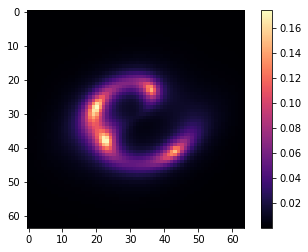

True image with noise.


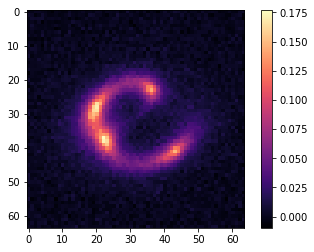

Image data
{'src_light_e1': 0.2586586502764554, 'lens_mass_gamma': 1.7476866515467957, 'lens_mass_center_y': -0.04254594579306117, 'lens_mass_e1': -0.0019344217722709546, 'img_filename': 'X_0000040.npy', 'src_light_center_x': 0.0666606974830339, 'external_shear_gamma_ext': 0.05621896938274424, 'lens_mass_center_x': 0.04447464276155878, 'lens_mass_e2': -0.21863827627112475, 'external_shear_dec_0': -0.04254594579306117, 'external_shear_ra_0': 0.04447464276155878, 'src_light_e2': -0.2979420316652591, 'lens_mass_theta_E': 0.9779771511036928, 'external_shear_psi_ext': -0.2187388114473809, 'src_light_n_sersic': 2.4246063799468183, 'src_light_R_sersic': 0.5168324861130238, 'total_magnification': 10.75538031714708, 'src_light_center_y': 0.06062729637749242, 'src_light_magnitude': 23.24981091894046}


In [3]:
# Select the image we want to forward model.
image_index = 40
fow_model_nn1.select_image(image_index)

In [4]:
# Initialize our sampler
walker_ratio = 50
save_path_chains = os.path.join(root_path,'forward_modeling/%s.h5'%(fow_model_nn1.true_values['img_filename'][:-4]))
fow_model_nn1.initialize_sampler(walker_ratio,save_path_chains)

In [5]:
# And run the sampler
n_samps = 1
fow_model_nn1.run_sampler(n_samps)

  0%|          | 0/1 [00:00<?, ?it/s]

Using chains found at /home/swagnercarena/ovejero/forward_modeling/X_0000040.h5


100%|██████████| 1/1 [00:02<00:00,  2.79s/it]


Computing the MCMC...
Number of walkers =  700
Burn-in iterations:  0
Sampling iterations (in current run): 1
3.1638638973236084 time taken for MCMC sampling


In [6]:
# Let's take a look at the chains to make sure they seem converged
burnin = 2000
# fow_model_nn1.plot_chains(burnin)

In [7]:
num_samples = 10000
sample_save_dir = os.path.join(root_path,'forward_modeling/nn1_%s_samps'%(
    fow_model_nn1.true_values['img_filename'][:-4]))

In [12]:
# Now let's look at the corner plot of the parameters we care about (the lens parameters)
color_map = ['#1b9e77','#000000']
truth_color = '#e7298a'
plot_limits = [(-0.03,0.09),(-0.06,0.06),(0.00,0.08),(-0.08,0.00),(-0.08,0.08),(-0.32,-0.16),(1.6,2.0),
              (-0.06,0.00)]
# These contours are too wide to use the correct plot limits
save_fig_path = 'figures/nn1_%s_fig.pdf'%(fow_model_nn1.true_values['img_filename'][:-4])
fig = fow_model_nn1.plot_posterior_contours(burnin,num_samples,sample_save_dir=sample_save_dir,color_map=color_map,
                                 plot_limits=plot_limits,truth_color=truth_color,save_fig_path=save_fig_path)

Loading samples from /home/swagnercarena/ovejero/forward_modeling/nn2_X_0000040_samps


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f433cf4d7b8> (for post_execute):


KeyboardInterrupt: 

## Forward Modeling NN2

Is model built: True
Loaded weights /home/swagnercarena/ovejero/models/nn2_slr.h5
True image without noise.


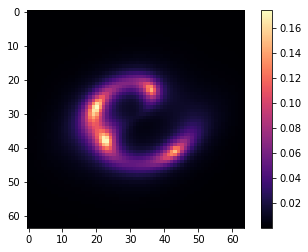

True image with noise.


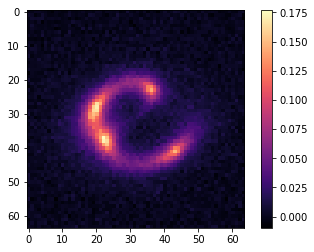

  0%|          | 0/1 [00:00<?, ?it/s]

Image data
{'src_light_e1': 0.2586586502764554, 'lens_mass_gamma': 1.7476866515467957, 'lens_mass_center_y': -0.04254594579306117, 'lens_mass_e1': -0.0019344217722709546, 'img_filename': 'X_0000040.npy', 'src_light_center_x': 0.0666606974830339, 'external_shear_gamma_ext': 0.05621896938274424, 'lens_mass_center_x': 0.04447464276155878, 'lens_mass_e2': -0.21863827627112475, 'external_shear_dec_0': -0.04254594579306117, 'external_shear_ra_0': 0.04447464276155878, 'src_light_e2': -0.2979420316652591, 'lens_mass_theta_E': 0.9779771511036928, 'external_shear_psi_ext': -0.2187388114473809, 'src_light_n_sersic': 2.4246063799468183, 'src_light_R_sersic': 0.5168324861130238, 'total_magnification': 10.75538031714708, 'src_light_center_y': 0.06062729637749242, 'src_light_magnitude': 23.24981091894046}
Using chains found at /home/swagnercarena/ovejero/forward_modeling/X_0000040.h5


100%|██████████| 1/1 [00:03<00:00,  3.04s/it]


Computing the MCMC...
Number of walkers =  700
Burn-in iterations:  0
Sampling iterations (in current run): 1
3.45055890083313 time taken for MCMC sampling


In [9]:
config_path = root_path + 'configs/nn2_slr.json'
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)

fow_model_nn2 = forward_modeling.ForwardModel(cfg)
image_index = 40
fow_model_nn2.select_image(image_index)
n_walkers = 50
save_path_chains = os.path.join(root_path,'forward_modeling/%s.h5'%(fow_model_nn2.true_values['img_filename'][:-4]))
fow_model_nn2.initialize_sampler(n_walkers,save_path_chains)
n_samps = 1
fow_model_nn2.run_sampler(n_samps)

In [10]:
num_samples = 10000
sample_save_dir = os.path.join(root_path,'forward_modeling/nn2_%s_samps'%(
    fow_model_nn2.true_values['img_filename'][:-4]))

Loading samples from /home/swagnercarena/ovejero/forward_modeling/nn2_X_0000040_samps


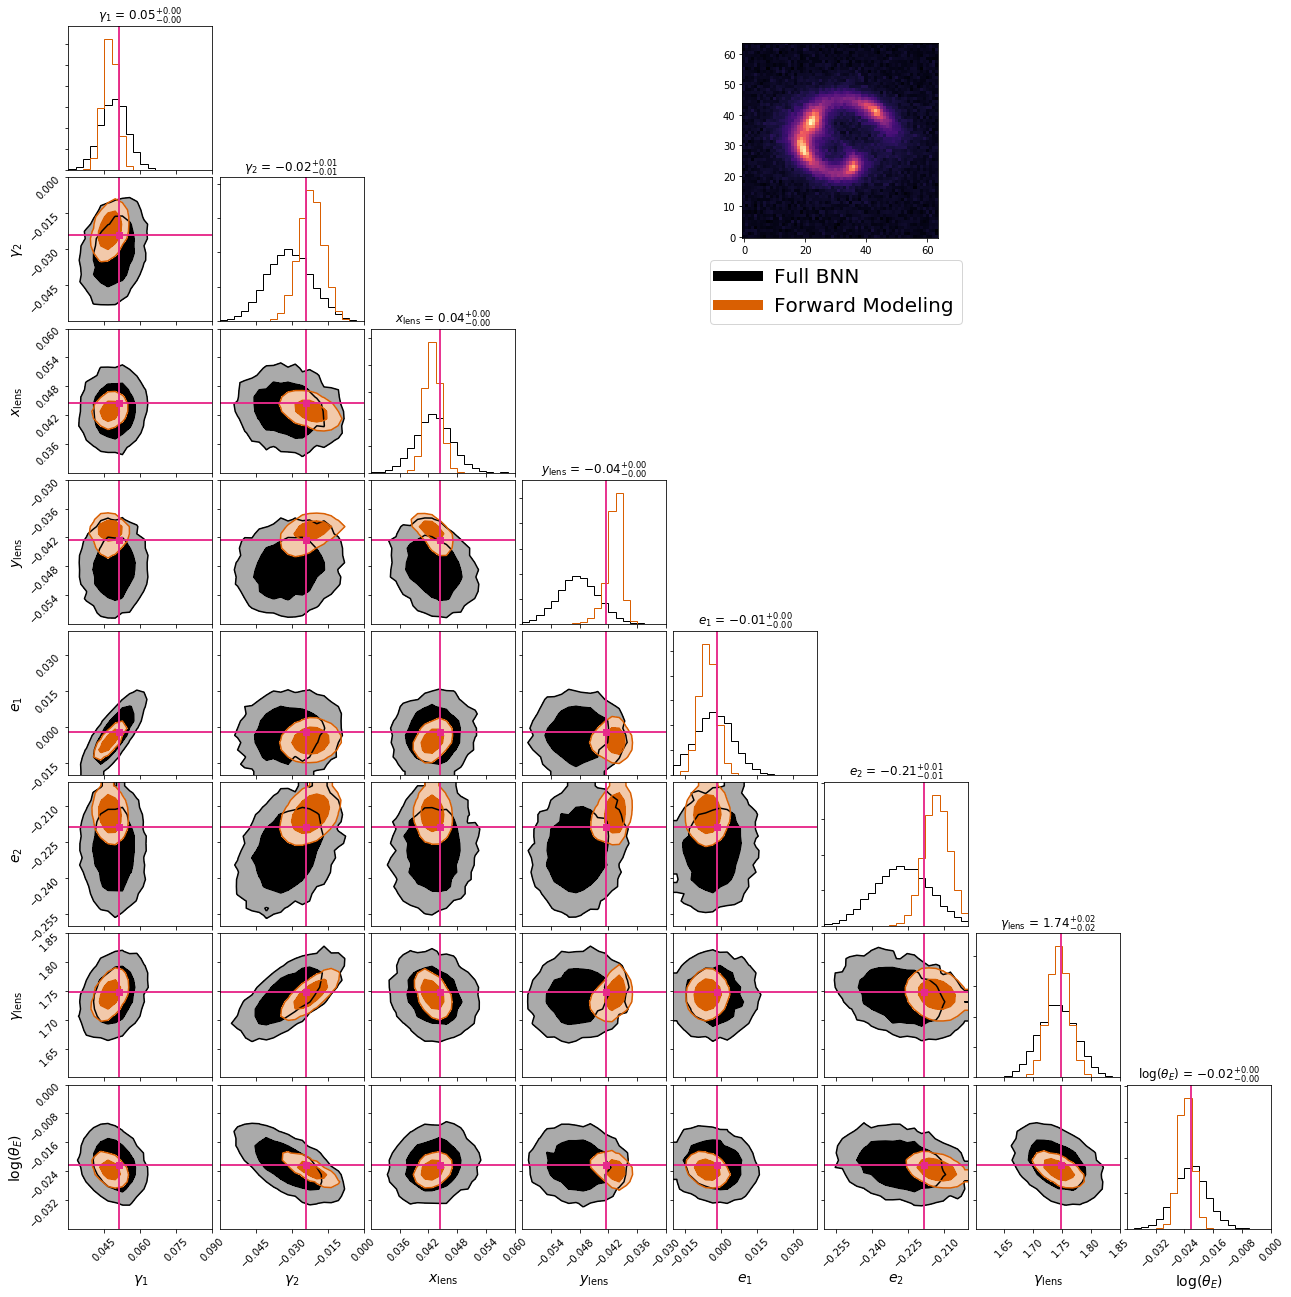

In [11]:
# Now let's look at the corner plot of the parameters we care about (the lens parameters)
color_map = ['#d95f02','#000000']
truth_color = '#e7298a'
plot_limits = [(0.03,0.09),(-0.06,0.00),(0.03,0.06),(-0.06,-0.03),(-0.02,0.04),(-0.26,-0.20),(1.6,1.85),
              (-0.04,0.00)]
save_fig_path = 'figures/nn2_%s_fig.pdf'%(fow_model_nn2.true_values['img_filename'][:-4])
fig = fow_model_nn2.plot_posterior_contours(burnin,num_samples,sample_save_dir=sample_save_dir,color_map=color_map,
                                 plot_limits=plot_limits,truth_color=truth_color,save_fig_path=save_fig_path)

## Forward Modeling NN3

Is model built: True
Loaded weights /home/swagnercarena/ovejero/models/nn3_slr.h5
True image without noise.


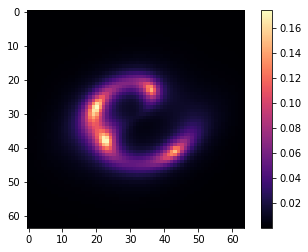

True image with noise.


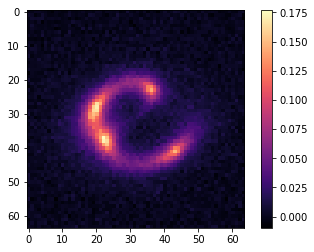

  0%|          | 0/1 [00:00<?, ?it/s]

Image data
{'src_light_e1': 0.2586586502764554, 'lens_mass_gamma': 1.7476866515467957, 'lens_mass_center_y': -0.04254594579306117, 'lens_mass_e1': -0.0019344217722709546, 'img_filename': 'X_0000040.npy', 'src_light_center_x': 0.0666606974830339, 'external_shear_gamma_ext': 0.05621896938274424, 'lens_mass_center_x': 0.04447464276155878, 'lens_mass_e2': -0.21863827627112475, 'external_shear_dec_0': -0.04254594579306117, 'external_shear_ra_0': 0.04447464276155878, 'src_light_e2': -0.2979420316652591, 'lens_mass_theta_E': 0.9779771511036928, 'external_shear_psi_ext': -0.2187388114473809, 'src_light_n_sersic': 2.4246063799468183, 'src_light_R_sersic': 0.5168324861130238, 'total_magnification': 10.75538031714708, 'src_light_center_y': 0.06062729637749242, 'src_light_magnitude': 23.24981091894046}
Using chains found at /home/swagnercarena/ovejero/forward_modeling/X_0000040.h5


100%|██████████| 1/1 [00:02<00:00,  2.89s/it]


Computing the MCMC...
Number of walkers =  700
Burn-in iterations:  0
Sampling iterations (in current run): 1
3.2681798934936523 time taken for MCMC sampling


In [13]:
config_path = root_path + 'configs/nn3_slr.json'
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)

fow_model_nn3 = forward_modeling.ForwardModel(cfg)
image_index = 40
fow_model_nn3.select_image(image_index)
n_walkers = 50
save_path_chains = os.path.join(root_path,'forward_modeling/%s.h5'%(fow_model_nn3.true_values['img_filename'][:-4]))
fow_model_nn3.initialize_sampler(n_walkers,save_path_chains)
n_samps = 1
fow_model_nn3.run_sampler(n_samps)

In [14]:
num_samples = 10000
sample_save_dir = os.path.join(root_path,'forward_modeling/nn3_%s_samps'%(
    fow_model_nn3.true_values['img_filename'][:-4]))

Loading samples from /home/swagnercarena/ovejero/forward_modeling/nn3_X_0000040_samps


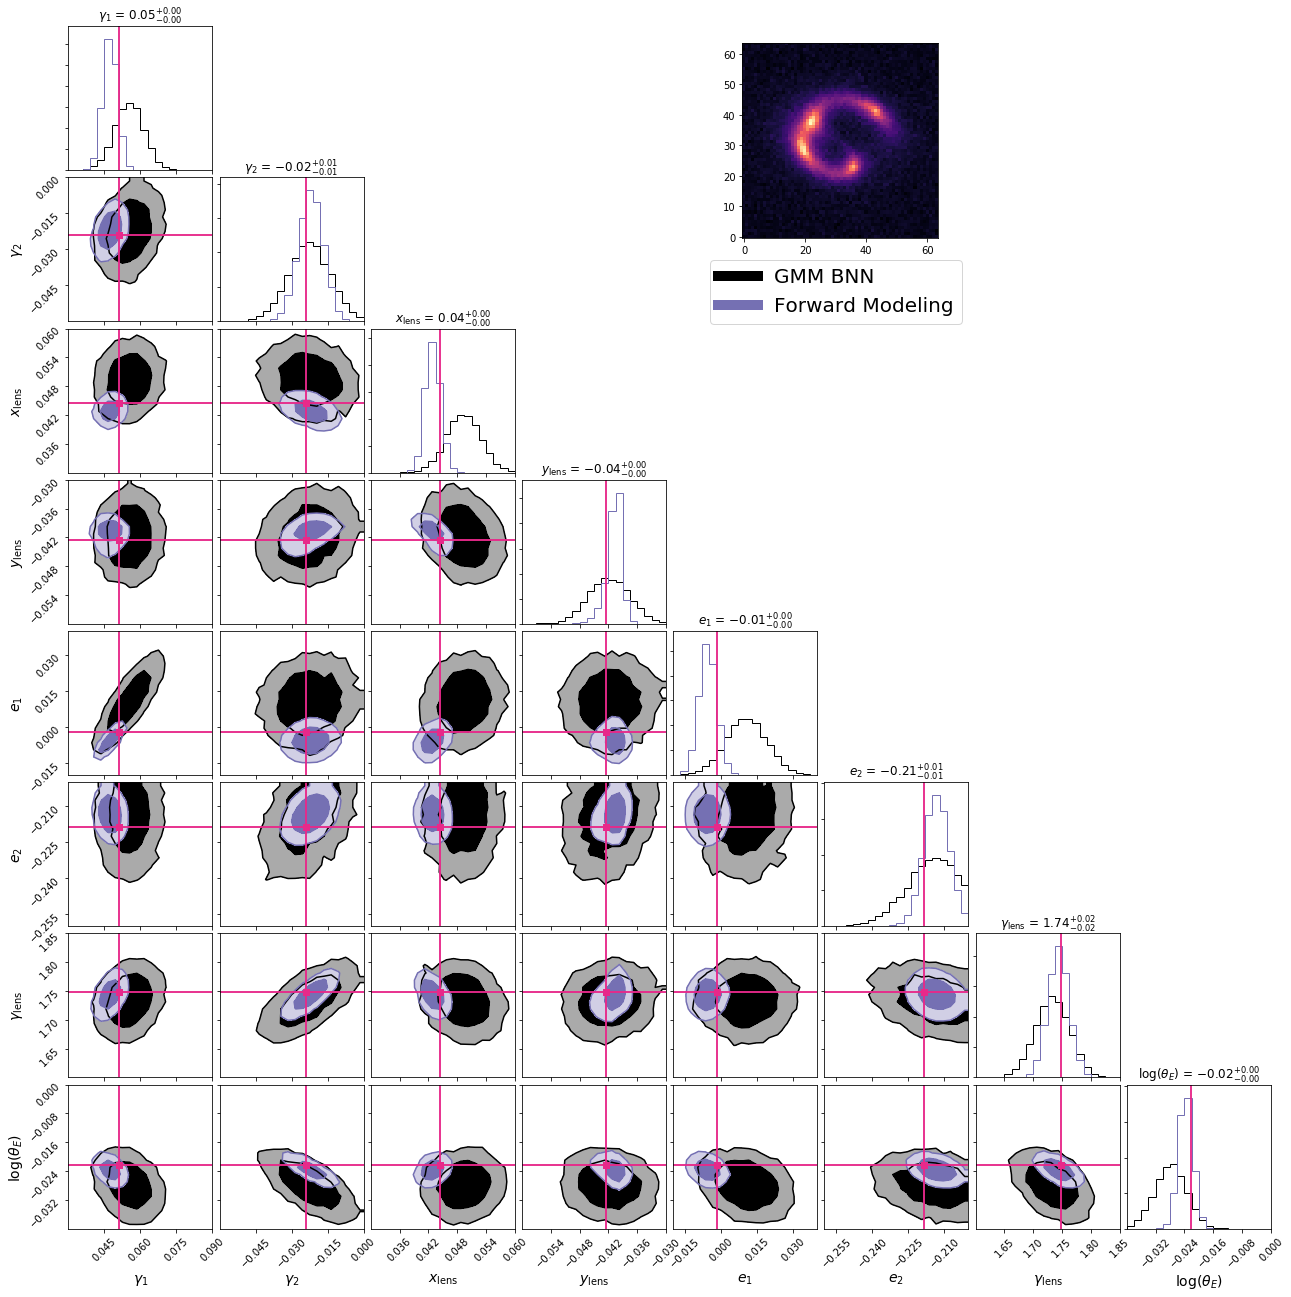

In [15]:
# Now let's look at the corner plot of the parameters we care about (the lens parameters)
color_map = ['#7570b3','#000000']
truth_color = '#e7298a'
plot_limits = [(0.03,0.09),(-0.06,0.00),(0.03,0.06),(-0.06,-0.03),(-0.02,0.04),(-0.26,-0.20),(1.6,1.85),
              (-0.04,0.00)]
save_fig_path = 'figures/nn3_%s_fig.pdf'%(fow_model_nn3.true_values['img_filename'][:-4])
fig = fow_model_nn3.plot_posterior_contours(burnin,num_samples,sample_save_dir=sample_save_dir,color_map=color_map,
                                 plot_limits=plot_limits,truth_color=truth_color,save_fig_path=save_fig_path)

## Combining Full and GMM

Loading samples from /home/swagnercarena/ovejero/forward_modeling/nn3_X_0000040_samps


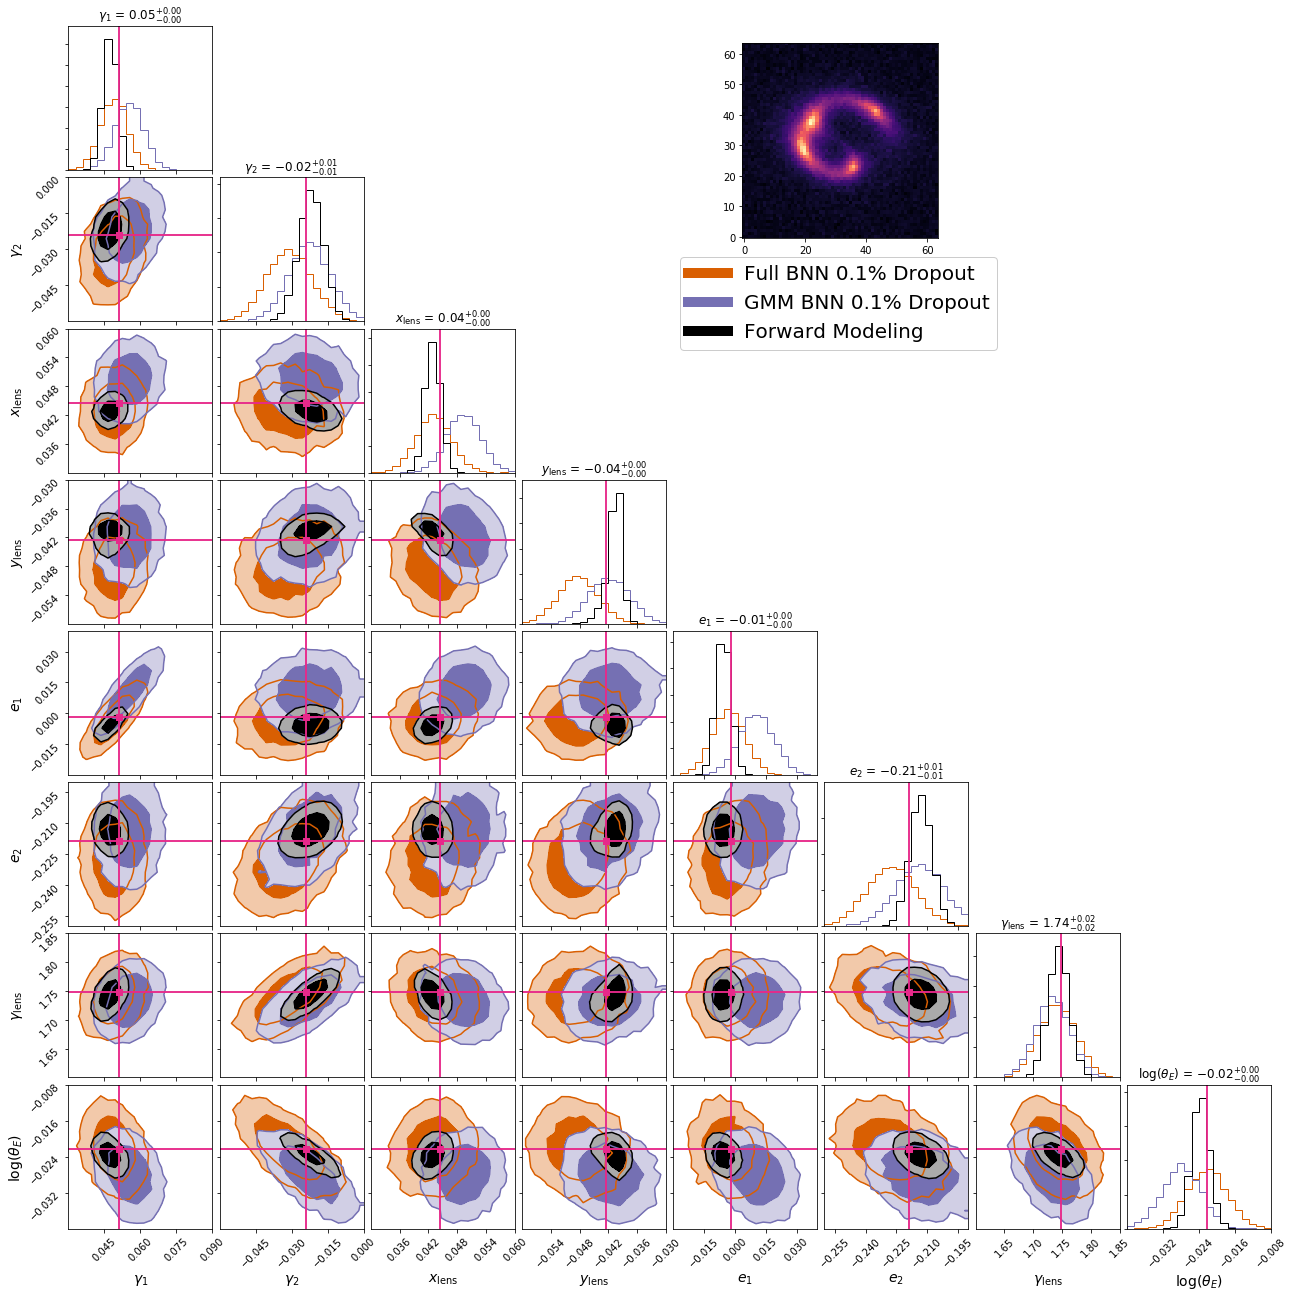

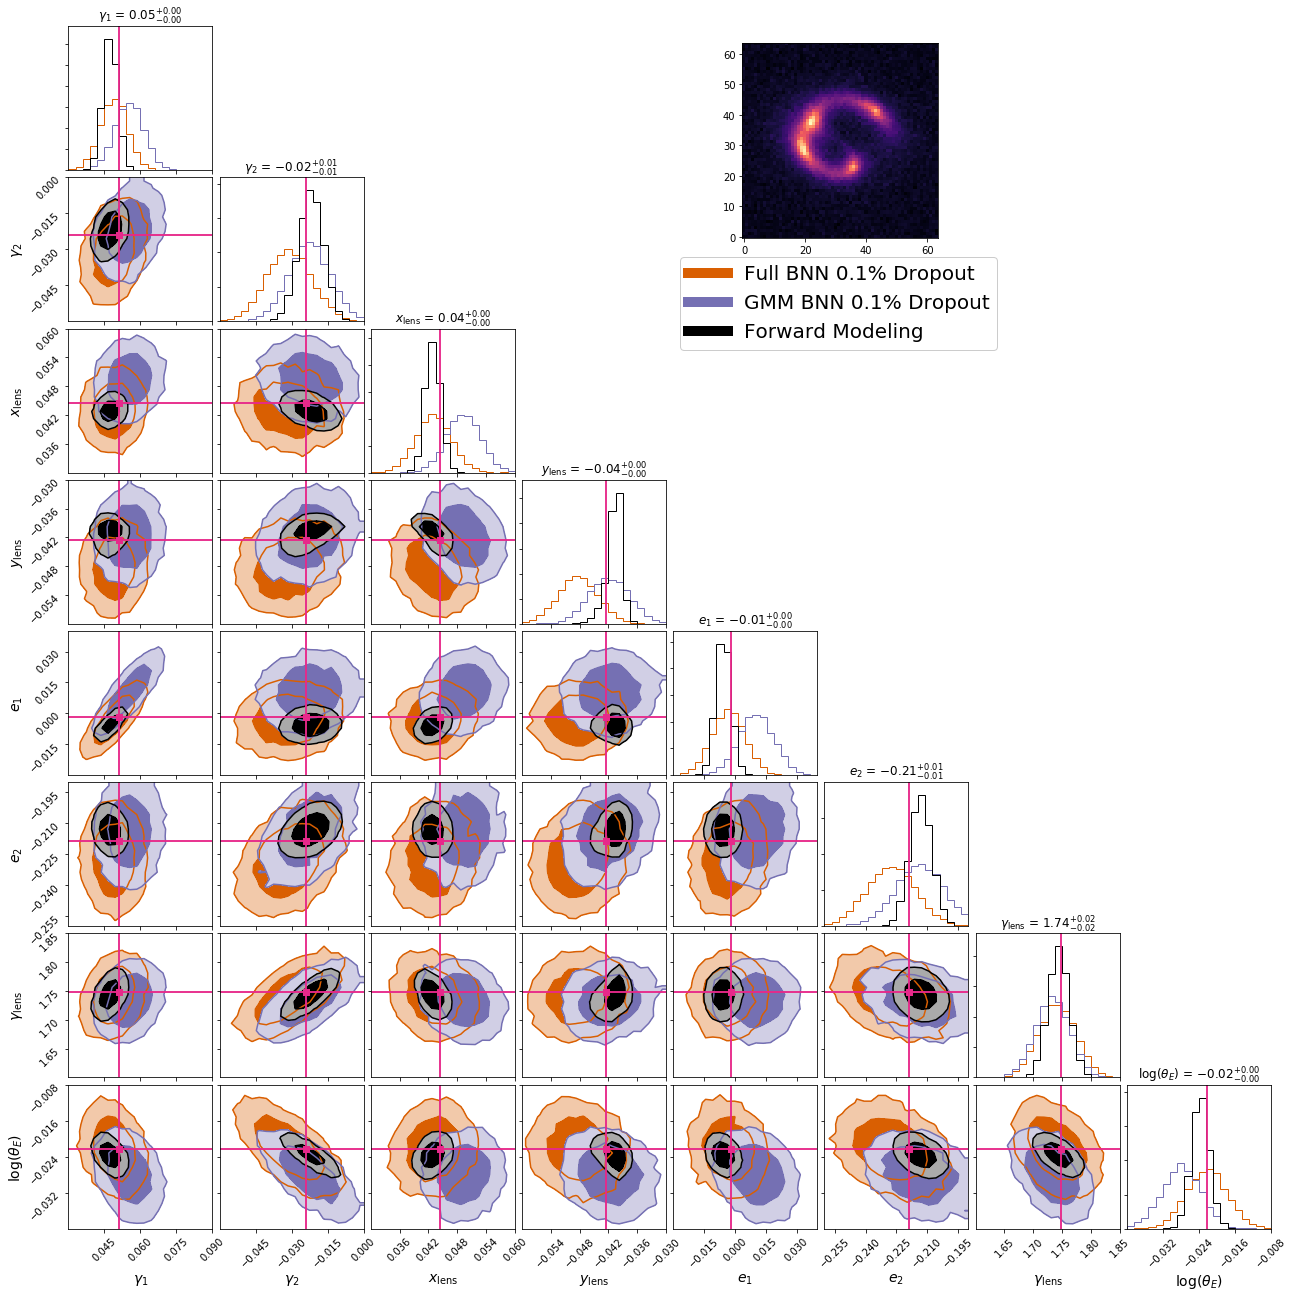

In [43]:
corner_bnn_samples = fow_model_nn2.predict_samps.reshape(-1,fow_model_nn2.predict_samps.shape[-1])
color_map = ['#d95f02','#7570b3','#000000']
hist_kwargs = {'density':True,'color':color_map[0]}
dpi = 400
plot_limits = [(0.03,0.09),(-0.06,0.00),(0.03,0.06),(-0.06,-0.03),(-0.03,0.04),(-0.26,-0.19),(1.6,1.85),
              (-0.04,-0.008)]
fig_new = corner.corner(corner_bnn_samples,
        bins=20,labels=fow_model_nn2.final_params_print_names,show_titles=True,
        plot_datapoints=False,label_kwargs=dict(fontsize=14),levels=[0.68,0.95],
        dpi=dpi, color=color_map[0],fig=None,fill_contours=True,
        range=plot_limits,hist_kwargs=hist_kwargs)
fig_new = fow_model_nn3.plot_posterior_contours(burnin,num_samples,sample_save_dir=sample_save_dir,
                                                color_map=color_map[1:],
                                 plot_limits=plot_limits,truth_color=truth_color,save_fig_path=save_fig_path,
                                           fig=fig_new,show_plot=False,dpi=dpi)
handles = [Line2D([0], [0], color=color_map[0], lw=10),
           Line2D([0], [0], color=color_map[1], lw=10),
           Line2D([0], [0], color=color_map[2], lw=10)]
fig_new.legend(handles,[r'Full BNN 0.1% Dropout',r'GMM BNN 0.1% Dropout','Forward Modeling'],loc=(0.525,0.73),
    fontsize=20,framealpha=1.0)
fig_new.savefig('figures/fow_model_comp.pdf')
fig_new


## Inspect Validation Lenses

In [ ]:
# Let's print a selection of some of our validation lenses
n_columns = 5
n_images = 25
plt.figure(figsize=(n_images//n_columns*10, n_columns*9))
rcParams.update({'font.size': 31})
for image_index in range(1,n_images+1):
    plt.subplot(n_images//n_columns, n_columns, image_index)
    img_filename = ('X_'+'0'*(6-int(np.log10(image_index)))+str(image_index)+'.npy')
    img = np.load(os.path.join(fow_model.cfg['validation_params']['root_path'],img_filename)).astype(np.float32)
    img = fow_model.noise_function.add_noise(img).numpy()
    if image_index == 1:
        norm = ImageNormalize(img, interval=MinMaxInterval(), stretch=AsinhStretch())
    plt.imshow(np.abs(img),origin='lower',cmap=cm.magma,norm=norm)
    plt.colorbar()
plt.show()
rcParams.update({'font.size': 10})